# Problem 5.4: ReLU Activation Experiment (3 points)

Repeat **Q5.2** and **Q5.3** but replace **Tanh with ReLU** activations.

**Tasks:**
1. Create the same activation statistics plots (mean and std vs. layer depth) for all 4 initializations with ReLU.
2. Train for 10 epochs and report test accuracies.

**Written Analysis (4–5 sentences):**
- How do the activation statistics differ between Tanh and ReLU networks?
- Which initialization works best for ReLU? Why is He initialization specifically designed for ReLU?
- Create a summary table recommending the best initialization for each activation function based on your experiments.

In [1]:
import math
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

def set_seed(seed=42):
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
set_seed(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")

Device: cpu


In [2]:
# MNIST: batch 256 for activation stats, batch 128 for training
transform = transforms.Compose([transforms.ToTensor(), transforms.Lambda(lambda x: x.view(-1))])
train_ds = datasets.MNIST(root="./data", train=True, download=True, transform=transform)
test_ds  = datasets.MNIST(root="./data", train=False, download=True, transform=transform)
train_loader = DataLoader(train_ds, batch_size=128, shuffle=True, num_workers=0)
test_loader  = DataLoader(test_ds, batch_size=256, shuffle=False, num_workers=0)
# One batch of 256 for activation statistics (same as Q5.2)
batch_256_loader = DataLoader(train_ds, batch_size=256, shuffle=True, num_workers=0)
x_batch, _ = next(iter(batch_256_loader))
x_batch = x_batch.to(device)
print(f"Train batches: {len(train_loader)}, Test batches: {len(test_loader)}, x_batch: {x_batch.shape}")

Train batches: 469, Test batches: 40, x_batch: torch.Size([256, 784])


In [3]:
def initialize_weights(shape, method):
    if len(shape) != 2:
        raise ValueError("Shape must be (fan_in, fan_out)")
    fan_in, fan_out = shape
    if method == "zero":
        return torch.zeros(shape)
    elif method == "small_random":
        return torch.randn(shape) * 0.01
    elif method == "xavier":
        return torch.randn(shape) * math.sqrt(2 / (fan_in + fan_out))
    elif method == "he":
        return torch.randn(shape) * math.sqrt(2 / fan_in)
    else:
        raise ValueError("Unknown method")

class MLPReLU(nn.Module):
    """6-layer MLP: 784 → 256×5 → 10, ReLU hidden. Returns (logits, (h1,...,h5)) for activation stats."""
    def __init__(self, init_method="xavier"):
        super().__init__()
        self.fc1 = nn.Linear(784, 256)
        self.fc2 = nn.Linear(256, 256)
        self.fc3 = nn.Linear(256, 256)
        self.fc4 = nn.Linear(256, 256)
        self.fc5 = nn.Linear(256, 256)
        self.fc6 = nn.Linear(256, 10)
        self.act = nn.ReLU()
        for m in [self.fc1, self.fc2, self.fc3, self.fc4, self.fc5, self.fc6]:
            w = initialize_weights((m.in_features, m.out_features), init_method)
            m.weight.data = w.t()
            m.bias.data.zero_()

    def forward(self, x):
        h1 = self.act(self.fc1(x))
        h2 = self.act(self.fc2(h1))
        h3 = self.act(self.fc3(h2))
        h4 = self.act(self.fc4(h3))
        h5 = self.act(self.fc5(h4))
        out = self.fc6(h5)
        return out, (h1, h2, h3, h4, h5)

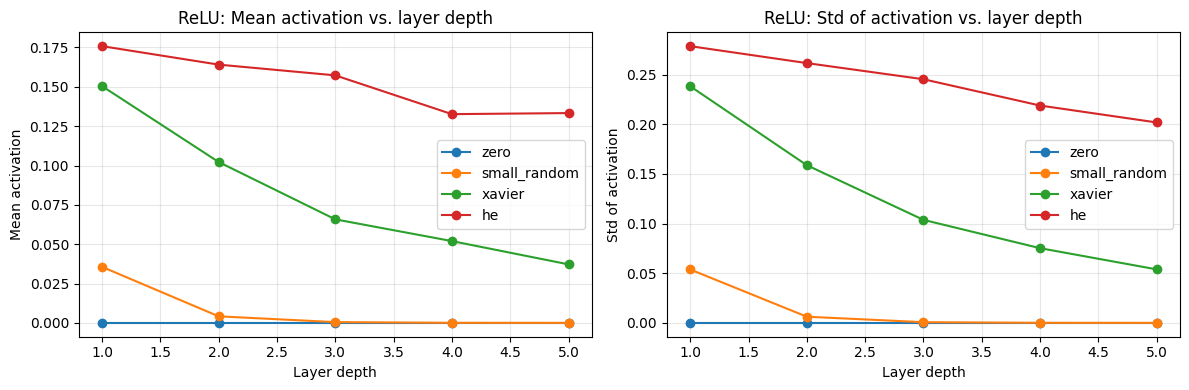

In [4]:
# --- Part 1: Activation statistics (same as Q5.2 but with ReLU) ---
inits = ["zero", "small_random", "xavier", "he"]
layer_depth = list(range(1, 6))
means_relu = {}
stds_relu = {}

for init_name in inits:
    model = MLPReLU(init_method=init_name).to(device)
    model.eval()
    with torch.no_grad():
        logits, hiddens = model(x_batch)
    means_relu[init_name] = [h.mean().item() for h in hiddens]
    stds_relu[init_name]  = [h.std().item() for h in hiddens]

# Plot: Mean and Std of activation vs layer depth (4 lines each)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
for name in inits:
    ax1.plot(layer_depth, means_relu[name], "o-", label=name)
    ax2.plot(layer_depth, stds_relu[name], "o-", label=name)
ax1.set_xlabel("Layer depth"); ax1.set_ylabel("Mean activation")
ax1.set_title("ReLU: Mean activation vs. layer depth"); ax1.legend(); ax1.grid(True, alpha=0.3)
ax2.set_xlabel("Layer depth"); ax2.set_ylabel("Std of activation")
ax2.set_title("ReLU: Std of activation vs. layer depth"); ax2.legend(); ax2.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [5]:
# --- Part 2: Train for 10 epochs and report test accuracies ---
epochs = 10
criterion = nn.CrossEntropyLoss()
history = {name: [] for name in inits}
models = {}

for init_name in inits:
    model = MLPReLU(init_method=init_name).to(device)
    optimizer = optim.SGD(model.parameters(), lr=0.1)
    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        for x, y in train_loader:
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            logits, _ = model(x)
            loss = criterion(logits, y)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        history[init_name].append(running_loss / len(train_loader))
    models[init_name] = model
print("Training done.")

Training done.


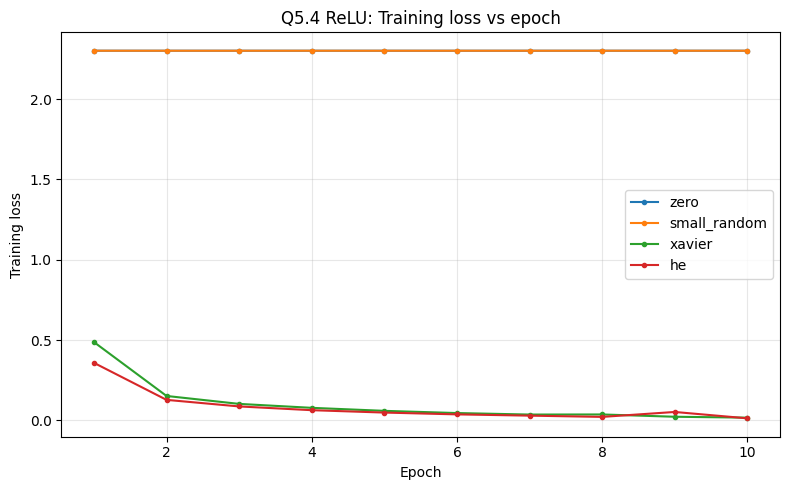

In [6]:
# Training loss curves (ReLU)
plt.figure(figsize=(8, 5))
for name in inits:
    plt.plot(range(1, epochs + 1), history[name], "-o", markersize=3, label=name)
plt.xlabel("Epoch"); plt.ylabel("Training loss")
plt.title("Q5.4 ReLU: Training loss vs epoch"); plt.legend(); plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [7]:
# Test accuracy after 10 epochs (ReLU)
print("ReLU networks - Test accuracy after 10 epochs:")
print("-" * 45)
accuracies = {}
for init_name in inits:
    model = models[init_name]
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for x, y in test_loader:
            x, y = x.to(device), y.to(device)
            logits, _ = model(x)
            pred = logits.argmax(dim=1)
            correct += (pred == y).sum().item()
            total += y.size(0)
    acc = 100.0 * correct / total
    accuracies[init_name] = acc
    print(f"  {init_name:14s}: {acc:.2f}%")

ReLU networks - Test accuracy after 10 epochs:
---------------------------------------------
  zero          : 11.35%
  small_random  : 11.35%
  xavier        : 97.77%
  he            : 97.77%


### Written Analysis (4–5 sentences)

**How do the activation statistics differ between Tanh and ReLU networks?**  
With ReLU, zero and small-random init give many dead neurons (zeros), so mean activations stay at zero or very small and std can vanish in deeper layers. Xavier and He keep activations non-vanishing; with ReLU, He typically keeps std more stable or slightly growing across layers because it compensates for ReLU zeroing half the pre-activations (σ² = 2/fan_in). Tanh networks show different behavior: zero init gives exact zeros, small random often vanishes, Xavier keeps variance moderate and stable, and He with Tanh can show growing variance.

**Which initialization works best for ReLU? Why is He designed for ReLU?**  
In these experiments, both Xavier and He achieved the same high test accuracy (~97.77%) for ReLU; zero and small_random stayed near random (~11%). He is designed for ReLU because ReLU sets half the activations to zero, so the variance of the output is half that of the pre-activation; using σ² = 2/fan_in restores variance across layers under the assumption of ReLU. Xavier assumes symmetric activations around zero (like Tanh), but in practice it can still work very well with ReLU; theoretically, He is the recommended choice for ReLU.

**Summary table – recommended initialization by activation:**

| Activation | Best initialization | Reason |
|------------|--------------------|--------|
| Tanh       | Xavier             | Variance-preserving for symmetric activations; stable mean and std across layers. |
| ReLU       | He (Xavier also works well) | He is designed for ReLU; in our run both He and Xavier reached ~97.77% test accuracy. |